## Spatio-temporal functional data analysis for wireless sensor networks data 논문

In [1]:
load("hourly_data.RData")
ls()   # 현재 존재하는 R 객체 확인

[1] "full_data"

In [2]:
dim(full_data)

[1] 10487996        7

In [3]:
head(full_data)

grid,date,PM10,PM25,lon,lat,A
632132,2014010101,132,NA,128.8827,37.7428,2014-01-01 01:00:00
632132,2014010102,121,NA,128.8827,37.7428,2014-01-01 02:00:00
632132,2014010103,101,NA,128.8827,37.7428,2014-01-01 03:00:00
632132,2014010104,82,NA,128.8827,37.7428,2014-01-01 04:00:00
632132,2014010105,69,NA,128.8827,37.7428,2014-01-01 05:00:00
632132,2014010106,70,NA,128.8827,37.7428,2014-01-01 06:00:00


In [4]:
library(mgcv)
library(ftsa)
library(MFPCA)

Warning message:
"package 'mgcv' was built under R version 3.5.2"Loading required package: nlme
This is mgcv 1.8-27. For overview type 'help("mgcv-package")'.
Warning message:
"package 'ftsa' was built under R version 3.5.2"Loading required package: forecast

Attaching package: 'forecast'

The following object is masked from 'package:nlme':

    getResponse

Loading required package: rainbow
Warning message:
"package 'rainbow' was built under R version 3.5.2"Loading required package: MASS
Loading required package: pcaPP
Loading required package: sde
Warning message:
"package 'sde' was built under R version 3.5.2"Loading required package: stats4
Loading required package: fda
Warning message:
"package 'fda' was built under R version 3.5.2"Loading required package: splines
Loading required package: Matrix

Attaching package: 'fda'

The following object is masked from 'package:forecast':

    fourier

The following object is masked from 'package:graphics':

    matplot

Loading required pa

In [5]:
################################################################################ 
#### generate data : X ( time=24*60 days (2014/01/01~2014/3/1), grid=50 in Korea )
################################################################################ 
grid_pt <- unique(full_data$grid)[1:50]   # grid 변수의 unique한 값 50개를 뽑음
X <- vector()
for (i in 1:length(grid_pt)){   # grid별로 각각 24*60개의 시계열 데이터를 뽑아서 rbind
    X <- rbind(X, full_data[which(full_data$grid==grid_pt[i]),][1:(24*60),] )
}
colnames(X)[7] <- 'Rdate'
X$time_in_day <- rep(c(1:24), 60)   # 시간 변수 추가(60일간의 시간별 데이터)
head(X)

grid,date,PM10,PM25,lon,lat,Rdate,time_in_day
632132,2014010101,132,NA,128.8827,37.7428,2014-01-01 01:00:00,1
632132,2014010102,121,NA,128.8827,37.7428,2014-01-01 02:00:00,2
632132,2014010103,101,NA,128.8827,37.7428,2014-01-01 03:00:00,3
632132,2014010104,82,NA,128.8827,37.7428,2014-01-01 04:00:00,4
632132,2014010105,69,NA,128.8827,37.7428,2014-01-01 05:00:00,5
632132,2014010106,70,NA,128.8827,37.7428,2014-01-01 06:00:00,6


In [6]:
na_index <- which(is.na(X$PM10)==T)   # PM10이 NA인 값의 index 저장
na_index

[1]   154   155   322   470   471   853   854  1042  1051  1052  1053  1054
  [13]  1055  1056  1057  1058  1059  1060  1061  1062  1063  1064  1065  1066
  [25]  1067  1068  1069  1070  1071  1072  1073  1074  1075  1076  1077  1078
  [37]  1079  1080  1081  1082  1083  1084  1085  1086  1087  1088  1089  1090
  [49]  1091  1092  1093  1094  1145  1146  1147  1148  1149  1150  1151  1152
  [61]  1153  1154  1155  1156  1157  1158  1159  1160  1161  1162  1477  1478
  [73]  1479  1765  1766  1767  1906  1907  1936  2102  2103  2104  2105  2294
  [85]  2295  2442  2443  2583  2584  2585  2593  2594  2595  2596  2597  2598
  [97]  2599  2600  2601  2602  2603  2604  2605  2606  2607  2608  2609  2610
 [109]  2611  2612  2613  2614  2615  2616  2678  2746  2747  2748  2944  3018
 [121]  3019  3181  3182  3353  3354  3736  3737  3738  3903  4025  4026  4240
 [133]  4241  4455  4456  4620  4793  4794  4795  5176  5177  5178  5340  5341
 [145]  5462  5463  5464  5676  5677  5678  5821  5822  5823  5903  6062  6063
 [157]  6064  6399  6400  6401  6468  6590  6591  6913  6914  6915  6916  6917
 [169]  6918  6919  6920  6921  6922  6923  6924  6925  6926  6927  6928  6929
 [181]  6930  6931  6932  6933  6934  6935  6936  7357  7358  7359  7572  7573
 [193]  7691  7692  7693  8028  8029  8030  8195  8196  8366  8367  8800  8801
 [205]  9015  9131  9132  9133  9470  9471  9472  9637  9638  9806  9807 10090
 [217] 10091 10281 10282 10283 10284 10285 10286 10287 10450 10451 10452 10453
 [229] 10598 10599 10600 10622 10623 10624 10714 10715 10716 10717 10718 10719
 [241] 10720 10958 10959 10960 10961 11051 11052 11053 11054 11233 11234 11235
 [253] 11236 11237 11238 11239 11240 11241 11242 11243 11244 11245 11246 11247
 [265] 11248 11249 11250 11251 11252 11253 11254 11255 11256 11458 11459 11460
 [277] 11461 11462 11463 11677 11678 11917 11918 12016 12017 12018 12420 12421
 [289] 12578 12579 12580 12581 12582 12583 12584 12585 12586 12587 12588 12589
 [301] 12733 12734 12945 12946 12947 12948 12949 12950 12951 12952 13120 13121
 [313] 13354 13355 13456 13457 13860 13861 14031 14172 14173 14174 14295 14296
 [325] 14582 14583 14584 14585 14586 14587 14608 14610 14624 14831 14917 14918
 [337] 14919 14920 15277 15278 15279 15280 15550 15553 15554 15555 15556 15557
 [349] 15558 15559 15560 15561 15562 15563 15564 15565 15566 15567 15568 15569
 [361] 15570 15571 15572 15573 15574 15575 15576 15637 15638 15658 15659 16633
 [373] 16634 16635 16636 16637 16638 16639 16640 16641 16642 16643 16644 16645
 [385] 16646 16647 16648 16649 16650 16651 16652 16653 16654 16655 16656 16657
 [397] 16658 16659 16660 16661 16662 16663 16664 16665 16666 16667 16668 16669
 [409] 16670 16671 16672 16673 16836 16837 16838 16839 16840 16841 16842 16843
 [421] 16844 16845 16846 16847 16848 16849 16850 16851 16852 16853 16854 16855
 [433] 16856 16857 16858 16859 16860 16861 17917 18113 18275 18276 18841 18842
 [445] 18843 18844 18845 18846 18847 18848 18849 18850 18851 18852 18853 18873
 [457] 18874 19138 20208 20209 20210 20226 20227 20228 20229 20282 20283 20296
 [469] 20297 20298 20299 20317 20318 20319 20331 20332 20333 20334 20335 20336
 [481] 20337 20338 20339 20340 20341 20342 20343 20344 20345 20402 20419 20420
 [493] 20421 20422 20423 20424 20444 20445 20446 20447 20448 20449 20450 20460
 [505] 20556 20557 20558 20559 20730 21350 21351 21352 21353 21354 21355 21360
 [517] 21486 21487 21488 21489 21490 21491 21952 22168 22169 22170 22171 22172
 [529] 22173 22174 22175 22176 22177 22178 22179 22180 22181 22182 22183 22184
 [541] 22185 22186 22187 22188 22189 22190 22191 22192 22193 22194 22195 22196
 [553] 22197 22198 22199 22200 22201 22202 22203 22204 22205 22206 22207 22208
 [565] 22209 22210 22211 22212 22213 22214 22215 22216 22217 22218 22219 22220
 [577] 22221 22222 22223 22224 22225 22226 22227 22228 22229 22230 22231 22232
 [589] 22233 22234 22235 22236 22237 22740 22813 22836 23390 23675 23752 23753
 [601] 23754 23755 23812 23813 24182 24183 24276 2445

In [7]:
# NA값들을 인접한 10개 데이터의 평균으로 보간
for (k in 1:length(na_index)){   
    X$PM10[ na_index[k] ] <- mean( X$PM10[ c( (na_index[k]-5):(na_index[k]+5) ) ], na.rm=T)   ## interpolate NA terms
}

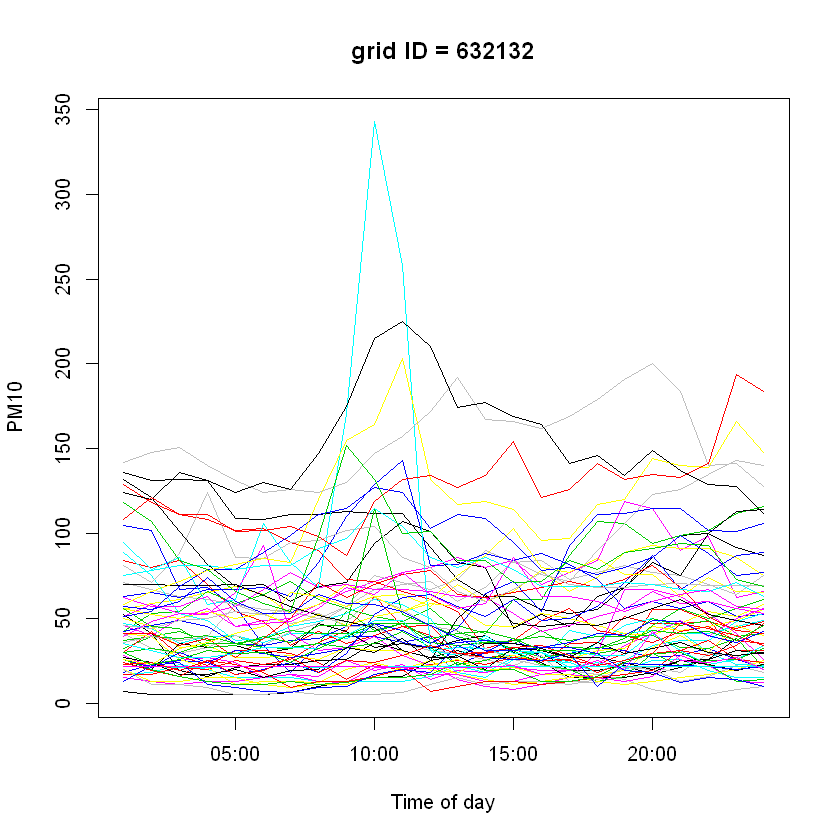

In [8]:
## to see daily cyclical pattern. (Fig 2-(b)) - raw data version
# Example plot for grid k=1
k <- 1
grid1 <- X[which(X[,1] == grid_pt[k]), ]

i <- 1
tt <- c( (1 + 24*(i-1)) : (24*i) ) 
plot(grid1$Rdate[tt], grid1$PM10[tt], type='l', main=paste('grid ID =', grid_pt[k]), xlab='Time of day', ylab="PM10", ylim=range(grid1$PM10, na.rm=T) )
for (i in 2:60){
    tt <- c( (1 + 24*(i-1)) : (24*i) ) 
    lines(grid1$Rdate[1:24], grid1$PM10[tt], col=i)
}

In [9]:
## Smoothing the data
# 비어있는 matrix 생성
smoothed_X <- matrix(nrow=length(unique(X$grid)), ncol=60*24)  ## grid(50) * time(24*60)
dim(smoothed_X)

[1]   50 1440

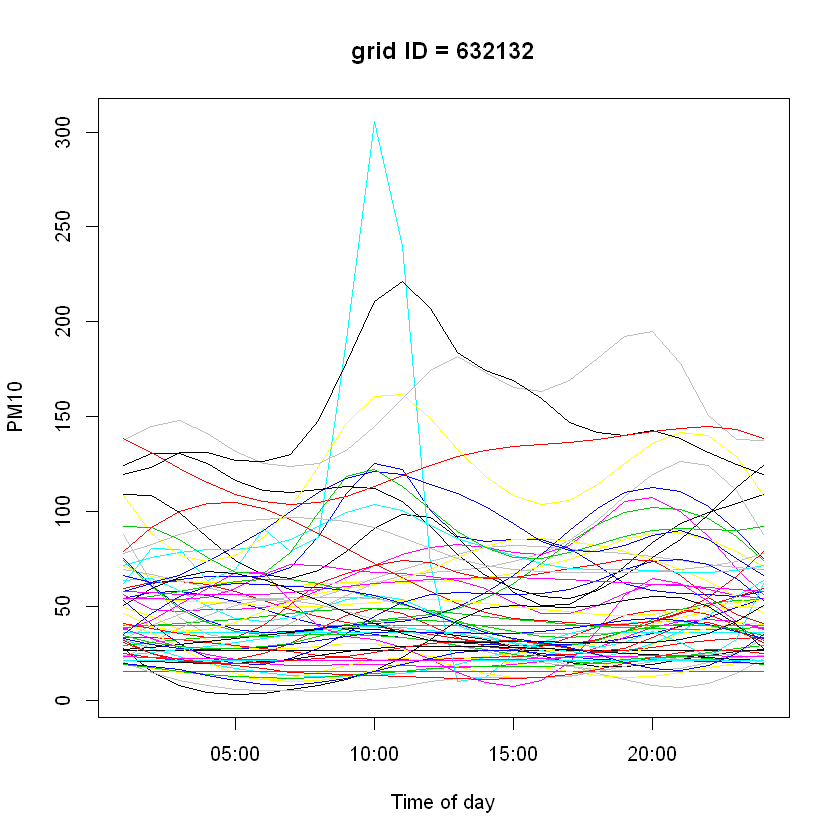

In [10]:
for (k in 1:length(unique(X$grid))){
    grid1 <- X[which(X[,1] == grid_pt[k]), ]
    for (i in 1:60){
        tt <- c( (1 + 24*(i-1)) : (24*i) ) 
    b <- gam(PM10[tt]~s(time_in_day[tt], bs='cc', k=24), data=grid1, method="REML")   # bs="cc": cyclic cubic regression splines
         smoothed_X[k, tt] <- b$fitted.values
    }
}

k <- 1
i <- 1
tt <- c( (1+24*(i-1) ) : (24*i) ) 
plot(grid1$Rdate[tt], smoothed_X[k,tt], type='l', main=paste('grid ID =', grid_pt[k]), xlab='Time of day', ylab="PM10", ylim=range(smoothed_X[k,], na.rm=T))
for (i in 2:60){
    tt <- c( (1+24*(i-1) ) :(24*i) ) 
    lines(grid1$Rdate[1:24], smoothed_X[k,tt], col=i)
}

In [11]:
#####  FPCA  (Need to apply into two type of grid (ex. grassland vs forest))
grass_data <- matrix(apply(smoothed_X[1:25,], 2, mean), 24, 60)   # grass에 해당하는 모든 grid를 각 시간마다 평균을 낸 데이터
forest_data <- matrix(apply(smoothed_X[26:50,], 2, mean), 24, 60)

fts_object_grass <- fts(x=c(1:24), grass_data)   # fts(): functional 객체 생성
fit_grass <- ftsm(fts_object_grass, order=3, method='classical')   # ftsm(): functional time series model - fpca, 24시간에 따라 pca(날짜가 아닌)

fts_object_forest <- fts(x=c(1:24), forest_data)  
fit_forest <- ftsm(fts_object_forest, order=3, method='classical')

Warning message in fts(x = c(1:24), grass_data):
"Please assign column name for the data matrix."Warning message in fts(y$x, basis_obj, start = ytsp[1], frequency = ytsp[3], xname = y$xname, :
"Please assign column name for the data matrix."Warning message in fts(y$x, y$y - fits$y, start = ytsp[1], frequency = ytsp[3], :
"Please assign column name for the data matrix."Warning message in fts(y$x, y$y, xname = y$xname, yname = y$yname):
"Please assign column name for the data matrix."Warning message in fts(x = c(1:24), forest_data):
"Please assign column name for the data matrix."Warning message in fts(y$x, basis_obj, start = ytsp[1], frequency = ytsp[3], xname = y$xname, :
"Please assign column name for the data matrix."Warning message in fts(y$x, y$y - fits$y, start = ytsp[1], frequency = ytsp[3], :
"Please assign column name for the data matrix."Warning message in fts(y$x, y$y, xname = y$xname, yname = y$yname):
"Please assign column name for the data matrix."

In [26]:
dim(smoothed_X[1:25,])

[1]   25 1440

In [28]:
length(apply(smoothed_X[1:25,], 2, mean))

[1] 1440

In [20]:
names(fit_grass)

[1] "x1"        "y1"        "y"         "basis"     "coeff"     "fitted"   
 [7] "residuals" "varprop"   "wt"        "v"         "basis2"    "coeff2"   
[13] "mean.se"   "call"

In [25]:
dim(grass_data)

[1] 24 60

In [23]:
dim(fit_grass$basis)   # PC score & mean(or median)

[1] 24  4

In [22]:
fit_grass$varprop

[1] 0.91196948 0.06213107 0.01819606

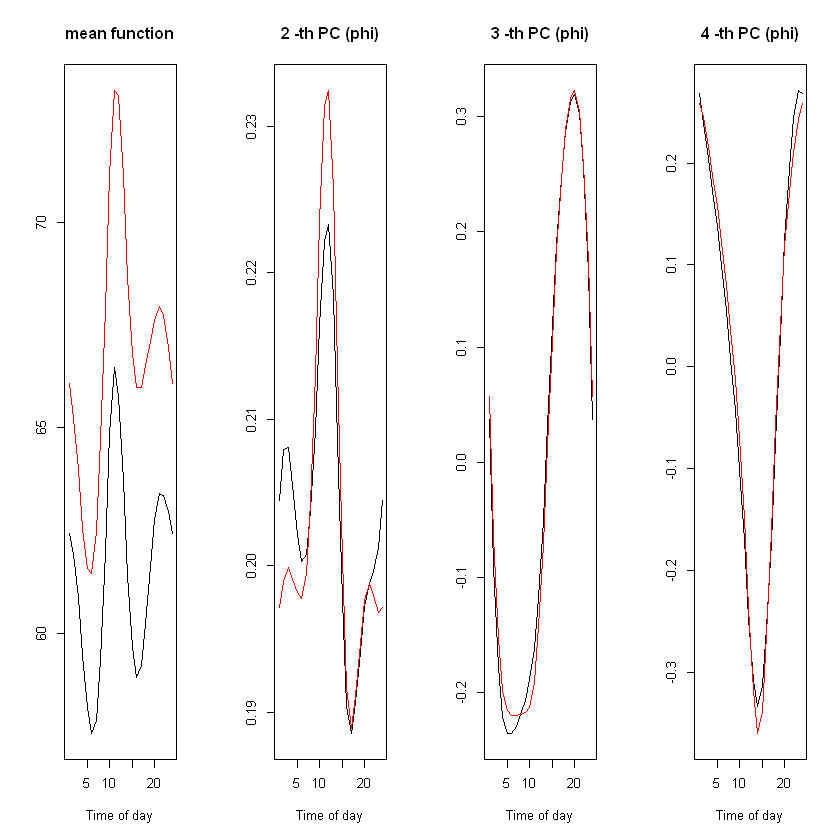

In [29]:
par(mfrow=c(1,4))
plot(fit_grass$basis[,1], type='l', main='mean function', xlab='Time of day', ylab='', ylim=range(fit_grass$basis[,1], fit_forest$basis[,1]))
lines(fit_forest$basis[,1], col=2)
# legend('topright', c('grass', 'forest'), lty=1, col=c(1,2))
for (k in 2:4){
    plot(fit_grass$basis[,k], type='l', main=paste(k ,'-th PC (phi)'), xlab='Time of day', ylab='', ylim=range(fit_grass$basis[,k], fit_forest$basis[,k]))
    lines(fit_forest$basis[,k], col=2)
    # legend('topright', c('grass', 'forest'), lty=1, col=c(1,2))
}

In [13]:
#### Smoothed ANOVA

## 1. grass
k <- 2
z <- as.vector(fit_grass$coeff[,k])
z <- rep(z, times=25)
loc_effect <- as.numeric(unique(X$grid)[1:25])
loc_effect <- rep(loc_effect, each=60)
# days_effect= rep( unique(format((X$Rdate), format="%m-%d"))[-61] , 25)
days_effect <- rep(1:60, 25)

anova_data <- data.frame(z, loc_effect, days_effect)
b <- gamm(z~s(loc_effect)+s(days_effect)+te(loc_effect,days_effect), data=anova_data)  
anova(b$gam)


Family: gaussian 
Link function: identity 

Formula:
z ~ s(loc_effect) + s(days_effect) + te(loc_effect, days_effect)

Approximate significance of smooth terms:
                                 edf    Ref.df     F p-value
s(loc_effect)               1.000002  1.000002   0.0       1
s(days_effect)              8.906217  8.906217 324.2  <2e-16
te(loc_effect,days_effect)  0.002116 18.000000   0.0       1